In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import jax
from scipy.stats import beta
from jax.scipy.special import betaln as beta_fun_log
from jax.scipy.special import digamma
from numpy.random import multivariate_normal as mvn
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
!pip install mycolorpy
from mycolorpy import colorlist as mcp

##**GENERAZIONE DATI**

This is the model for cluster paramters (so a sort of $G_0$):
\begin{align*}
  \mu_k & \stackrel{\tiny\mbox{iid}}{\sim} \mathcal{N}_d\left(\mu_0,\ \sigma^2 \mathbb{I}_d\right) & k=1,...,K \\
\end{align*}
with K the number of clusters, not known a priori, defined during data generation
We will generalize then by assuming a prior over $\sigma^2$ that could be for example the implementation of a NNIG model in a DP mixture

Data model:
\begin{align*}
  X_i|\eta,z_i \stackrel{\tiny\mbox{und}}{\sim} \mathcal{N}_d\left(\mu_{z_i},\ \mathbb{I}_d\right) \quad \quad i=1,...,N
\end{align*}
with $\eta$ such that $\eta_k$ is equal to the mean and varianc for each cluster $k=1,....,K$

So the final DP mixture model is:
\begin{align*}
  X_i|\mu_i &\stackrel{\tiny\mbox{ind}}{\sim} \mathcal{N}_d\left(\mu_{z_i},\ \mathbb{I}_d\right) &i=1,...,N \\
  \mu_i|P &\stackrel{\tiny\mbox{iid}}{\sim} P \\
  P &\sim \mathcal{D}_{\alpha} & \\
  \alpha &= \mathcal{N}_d\left(0_d,\ \sigma^2\mathbb{I}_d\right)
\end{align*}

DA METTERE A POSTO, NEL PAPER C'E' LA DISTRIBUZIONE DI $x_n$ CONDIZIONATA \\
SEGUE FAMIGLIA ESPONENZIALE

1.0000000000000002


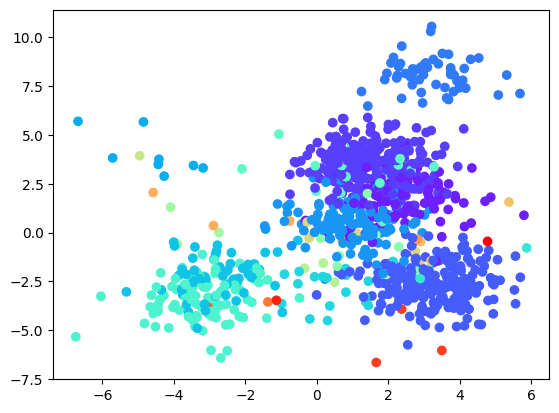

Final number of clusters:  26


In [ ]:
seed=2022
np.random.seed(seed)

# Instantiate the first topic
alpha = 5
n = 1000
d = 2

assignment = [0] # first point must be assigned to first cluster
rho_1 = beta(1, alpha).rvs()
remainder = 1-rho_1
rhos = [remainder, rho_1]
new_or_existk = [-1, 0]
ntopics =1
mu0 = np.zeros(d)
sigma2= 10
Id=np.eye(d)
#sigma0 = np.identity(d)

#cov1 = invwishart(df=2, scale=sigma0).rvs()
mu1 = mvn(mu0, sigma2*Id)

mus = [mu1]
#covs = [cov1]

for i in range(1, n):
  k = np.random.choice(new_or_existk, p=rhos)
  if k==-1:
    # generate new topic
    new_rho = beta(1, alpha).rvs() * remainder
    remainder -= new_rho
    rhos[0] = remainder
    rhos.append(new_rho)

    ntopics += 1
    assignment.append(ntopics-1) #zero-based indexing
    new_or_existk.append(ntopics-1)
    # generation of new cluster parameters
    # choose a distribution G_0 for the cluster parameters, then a distribution for data given the cluster parameters
    #new_cov = invwishart(df=d, scale=sigma0).rvs()
    new_mu = mvn(mean=mu0, cov=sigma2*Id)
    mus.append(new_mu)
    #covs.append(new_cov)
  else:
    assignment.append(k)

rhos=rhos/np.sum(rhos)

print(np.sum(rhos))

# data generation
datapoints = []
colors = cm.rainbow(np.linspace(0, 1, ntopics))
cs = []

for i in assignment:
  x = mvn(mean=mus[i], cov=Id)
  datapoints.append(x)
  cs.append(colors[i])

xs = [d[0] for d in datapoints]
ys = [d[1] for d in datapoints]
datapoints=jnp.array(datapoints)

plt.scatter(xs, ys, color=cs)
plt.show()
print('Final number of clusters: ',len(mus))

## CAVI FOR DP MIXTURE

\begin{align*}
  ELBO &= \mathbb{E}_q[log p(V|\alpha)] + \mathbb{E}_q[log p(\eta^*|\lambda)] \\
      & + \sum_{n=1}^N(\mathbb{E}_q[log p(Z_n|V)] + \mathbb{E}_q[log p(x_n|Z_n)]) \\
      & - \mathbb{E}_q[log q(V,\eta^*, Z)]
\end{align*}
We'll compute the values ot the 5 terms of the sum separated to make it easier to read, the third term has been computed on the paper \\
For the values of $\lambda$ we have concluded that, given the notation on the paper, $\lambda_1 = 0_d$ and $\lambda_2=\sigma^2$ \\
q is the variational ditribution, so
\begin{align*}
    q(v,\eta^*,z)=\prod_{t=1}^{T-1}q_{\gamma_t}(v_t)\prod_{t=1}^{T}q_{\tau_t}(\eta_t^*)\prod_{n=1}^{N}q_{\phi_n}(z_n)
\end{align*}

where $q_{\gamma_t}(v_t)$ are beta distributions, $q_{\tau_t}(\eta_t^*)$ are normal distributions with parameters $\tau_t$, and $q_{\phi_n}(z_n)$ are multinomial distributions \\
$\psi$ is the digamma function

\begin{align*}
  \mathbb{E}_q[log p(V|\alpha)] &= \mathbb{E}_q[log(\prod_{t=1}^T 1/B(1,\alpha)(1-v_t)^{\alpha-1})] \\
  &= \sum_{t=1}^T \mathbb{E}_q[-log(B(1,\alpha)) +(\alpha-1)log(1-v_t)] \\
  &= -T*log(B(1,\alpha)) + \sum_{t=1}^T (\alpha-1)\mathbb{E}_q[log(1-v_t)] \\
  &= -T*log(B(1,\alpha)) + (\alpha-1)\sum_{t=1}^{T-1} (\psi(\gamma_{t,2})-\psi(\gamma_{t,1}+\gamma_{t,2}))
\end{align*}
The last sum stops at T-1 because $v_T$ has been force to be 1 and the paper recalls us that $\mathbb{E}_q[log(1-v_T)]=0$ \\
The first part has been omitted in the code since it is constant every iteration

\begin{align*}
  \mathbb{E}_q[log p(\eta^*|\lambda)] &= \mathbb{E}_q[log\prod_{t=1}^T p(\eta_t^*|\lambda)] \\
  &= \sum_{t=1}^T \mathbb{E}_q[log(\frac{1}{(2\pi\sigma^2)^{d/2}}e^{-\frac{1}{2\sigma^2}({\eta_t^*}^T\eta_t^*)})] \\
  &= Tlog(\frac{1}{(2\pi\sigma^2)^{d/2}}) - \frac{1}{2\sigma^2} \sum_{t=1}^T \mathbb{E}_q[{\eta_t^*}^T\eta_t^*] \\
  &= Tlog(\frac{1}{(2\pi\sigma^2)^{d/2}}) - \frac{1}{2\sigma^2} \sum_{t=1}^T (\tau_{t,2} + \tau_{t,1}^T\tau_{t,1})
\end{align*}
Also here the first part is contsant through the iterations so it will not be computed in the code

The third term has been computed on the paper, we report the final result
\begin{align*}
  \mathbb{E}_q[log p(Z_n|V)] &= \sum_{t=1}^{T-1} (\sum_{j=i+1}^{T}\phi_{n,j}(\psi(\gamma_{i,2})-\psi(\gamma_{i,1}+\gamma_{i,2})) + \phi_{n,i}(\psi(\gamma_{t,1})-\psi(\gamma_{t,1}+\gamma_{t,2})))
\end{align*}
Here since $v_T=1$ we have assumed $\mathbb{E}_q[log v_T]$ equal to 0, the paper doen't explicitly say it, it only specifies the value of $\mathbb{E}_q[log (1-v_T)]$ (also equal to 0). This is why the firt summary stops at T-1 instead of T. \\
Moreover in front of this result there is a sum over n

\begin{align*}
  \mathbb{E}_q[log p(x_n|Z_n)] &= \mathbb{E}_q[log(\frac{1}{(2\pi)^{d/2}}e^{-\frac{1}{2}((x_n-\eta_{Z_n}^*)^T(x_n-\eta_{Z_n}^*))})] \\
  &= log(\frac{1}{(2\pi)^{d/2}})-\frac{1}{2}(x_n^Tx_n-2x_n^T\mathbb{E}_q[\eta_{Z_n}^*]+\mathbb{E}_q[{\eta_{Z_n}^*}^T\eta_{Z_n}^*]) \\
  &= log(\frac{1}{(2\pi)^{d/2}})-\frac{1}{2}(x_n^Tx_n-2x_n^T\sum_{t=1}^T\phi_{n,t}\mathbb{E}_q[\eta_t^*]+\sum_{t=1}^T \phi_{n,t}\mathbb{E}_q[{\eta_t^*}^T\eta_t^*]) \\
  &= log(\frac{1}{(2\pi)^{d/2}})-\frac{1}{2}(x_n^Tx_n-2x_n^T\sum_{t=1}^T\phi_{n,t}\tau_{t,1}+\sum_{t=1}^T \phi_{n,t}(\tau_{t,2}+\tau_{t,1}^T\tau_{t,1}))
\end{align*}

The first 2 terms are constant along the iterations so we can omit them
Also in front of this term there is a sum over n from 1 to N

\begin{align*}
  \mathbb{E}_q[log q(V,\eta^*, Z)] &= \mathbb{E}_q[log \prod_{t=1}^{T-1}q_{\gamma_t}(v_t)\prod_{t=1}^{T}q_{\tau_t}(\eta_t^*)\prod_{n=1}^{N}q_{\phi_n}(z_n)] \\
  &= \sum_{t=1}^{T-1} \mathbb{E}_q[logq_{\gamma_t}(v_t)] + \sum_{t=1}^{T} \mathbb{E}_q[logq_{\tau_t}(\eta_t^*)] + \sum_{n=1}^N \mathbb{E}_q[log q_{\phi_n}(z_n)] \\
  \mathbb{E}_q[logq_{\gamma_t}(v_t)] &= \mathbb{E}_q[-log(B(\gamma_{t,1},\gamma_{t,2}))+(\gamma_{t,1}-1)logv_t+(\gamma_{t,2}-1)log(1-v_t)] \\
  &=-log(B(\gamma_{t,1},\gamma_{t,2}))+(\gamma_{t,1}-1)(\psi(\gamma_{t,1})-\psi(\gamma_{t,1}+\gamma_{t,2}))+(\gamma_{t,2}-1)(\psi(\gamma_{t,2})-\psi(\gamma_{t,1}+\gamma_{t,2})) \\
  \mathbb{E}_q[logq_{\tau_t}(\eta_t^*)] &= \mathbb{E}_q[log(\frac{1}{(2\pi\tau_{t,2})^{d/2}}e^{-\frac{1}{2\tau_{t,2}}((\eta_t^*-\tau_{t,1})^T(\eta_t^*-\tau_{t,1}))})] \\
  &= -\frac{d}{2}log(2\pi)-\frac{d}{2}log(\tau_{t,2})-\frac{1}{2\tau_{t,2}}\mathbb{E}_q[(\eta_t^*-\tau_{t,1})^T(\eta_t^*-\tau_{t,1})] \\
  &= -\frac{d}{2}log(2\pi)-\frac{d}{2}log(\tau_{t,2})-\frac{1}{2\tau_{t,2}}\tau_{t,2} \\
  &= -\frac{d}{2}log(2\pi)-\frac{d}{2}log(\tau_{t,2})-\frac{1}{2} \\
  \mathbb{E}_q[log q_{\phi_n}(z_n)]&= \sum_{t=1}^Tlog(\phi_{n,t})\phi_{n,t}
\end{align*}

Again some parts of the computation are constant so they will not appear in the code \\

Finally we report the computation of the update of the $\phi$ according to our model \\
In particular the function $a(.)$ in our model is the square or, more precisely in a moltidimensional framework, $a(\eta)=\eta^T\eta$

\begin{align*}
  \phi_{n,t} &\propto exp(S_t) \\
  S_t &= \mathbb{E}_q[logV_t] + \sum_{i=1}^{t-1}\mathbb{E}_q[log(1-V_i)]+\mathbb{E}_q[\eta_t^*]^Tx_n - \mathbb{E}_q[{\eta_t^*}^T\eta_t^*] \\
  &= \psi(\gamma_{t,1})-\psi(\gamma_{t,1}+\gamma_{t,2})+\sum_{i=1}^{t-1}(\psi(\gamma_{i,1})-\psi(\gamma_{i,1}+\gamma_{i,2})) + \tau_{t,1}^Tx_n -(\tau_{t,2}+tau_{t,1}^T\tau_{t,1})
\end{align*}

In [ ]:

def update_phi(data, gamma, tau1, tau2):
    '''
    This function updates the values of phi according to the variational updated. We firstly find the loglikelihood then we apply the exponential function and finally we normalize it
    The input of the function are:
      - data: the (N,d) matrix of datapoints (N=#samples , d=#dimension)
      - gamma: the variational parameters gamma, so the parameters for the beta distribution of the weights in the approximation of the DP, (T-1,2) matrix
      - tau1: the variational parameters that want to approximate the posterior mean of the clusters, (T,d) matrix
      - tau2: the variational parameters for the posterior variance of the mean (knowing that the variance is tau2*np.eye(d)), (T,1) matrix
    The output of the function is the updated value of phi
    The value of T is decided by us and it's the maximum number of cluster the algorithm can detect, more specifically the approximation of the DP stops at the T-th unique value
    '''
    N = data.shape[0]
    T = tau1.shape[0]

    updated_phi = jnp.zeros((N, T))
    log_likelihood = jnp.zeros((N, T))
    sum_terms2 = jnp.zeros(T-1)

    # computation of log-likelihood for the first term (t=0)
    term1 = digamma(gamma[0, 0]) - digamma(gamma[0, 0] + gamma[0, 1])
    log_likelihood=log_likelihood.at[:,0].set(term1*jnp.ones(N) + data @ tau1[0,:] - 0.5 * (tau2[0, 0] + tau1[0, :] @ tau1[0, :].T)*jnp.ones(N))

    # vectorized computation of the log_likelihood for the remaining columns
    term1 = jnp.zeros((T-1,1))
    term1=term1.at[:(T-2),0].set(digamma(gamma[1:, 0]) - digamma(gamma[1:, 0] + gamma[1:, 1]))
    term2=digamma(gamma[:,1])-digamma(gamma[:,0]+gamma[:,1])
    sum_terms2= jnp.cumsum(term2)
    M=tau1[1:,:] @ tau1[1:,:].T
    log_likelihood=log_likelihood.at[:,1:].add( jnp.ones((N,1)) @ term1.T)
    log_likelihood=log_likelihood.at[:,1:].add( jnp.ones((N,1)) @ jnp.resize(sum_terms2,(T-1,1)).T)
    log_likelihood=log_likelihood.at[:,1:].add( data @ tau1[1:,:].T)
    log_likelihood=log_likelihood.at[:,1:].add(- 0.5 * jnp.ones((N,1)) @ jnp.resize(tau2[1:, 0] + jnp.diag(M),(T-1,1)).T)

    # exponential function applycation and then normalization
    updated_phi = jnp.nan_to_num(jnp.exp(log_likelihood-jnp.mean(log_likelihood,axis=1)[:,None]), nan=10**-10, posinf=float(10**10))
    updated_phi /= jnp.sum(updated_phi, axis=1, keepdims=True)
    updated_phi = updated_phi.at[:,:].max(10**(-5)/K)
    updated_phi = updated_phi.at[:,:].min(1-10**(-5)/K)
    updated_phi /= jnp.sum(updated_phi,axis=1,keepdims=True)

    return updated_phi



update_phi_jit=jit(update_phi)


def update_gamma(alpha, phi, T):
  '''
  This function updates the values of the gamma variational parameters
  Inputs:
    - alpha: value decided at the generation of data, the hyperparamters for the beta distribution of the weights in the DP
    - phi: the cluster allocation probabilities in the variational algorithm, (N,T) matrix
    - T: the value at which the sum of the DP P is stopped to approximate it
    The output is the updated gamma, (T-1,2) matrix
  '''
  gamma = jnp.ones((T-1,2))
  # first term update
  gamma=gamma.at[:,0].set(1+jnp.sum(phi[:,:(T-1)],axis=0))

  # we compute the "anti"-cumulative sum of the secodn term update
  anti_phi=phi[:,::-1]
  anti_phi_sum=jnp.cumsum(anti_phi,axis=1)
  phi_sum = anti_phi_sum[:,::-1]
  cumulative_phi_sum = jnp.sum(phi_sum[:,1:],axis=0)
  # second term update
  gamma=gamma.at[:, 1].set(alpha + cumulative_phi_sum)
  return gamma

update_gamma_jit=jit(update_gamma,static_argnums=(2))

def update_tau(data,phi,sigma):
  '''
  This function updates the values of the tau variational parameters
  Inputs:
    - data: (N,d) matrix of datapoints
    - phi: the cluster allocation probabilities in the variational algorithm, (N,T) matrix
    - sigma: the hyperparamer of the model for the prior variance of cluster means
    The outputs are the updated tau1, (T,d) matrix, and the updated tau2, (T,1) matrix
  '''

  tau1=jnp.matmul(phi.T,data)
  tau2=1/sigma+jnp.sum(phi,axis=0)
  tau1=tau1/tau2[:,None]
  tau2=1/tau2
  return tau1,tau2

update_tau_jit=jit(update_tau)

def compute_ELBO(data,gamma,tau1,tau2,phi,alpha,sigma):
  '''
  We aim to compute the value of the ELBO. Since we are interested in the improvement not in the absolute value in the computation the addictive values which are constant every iteration
  are not computed, since they would not change the improvement
  The inputs are:
   - data: (N,d) matrix of datapoints
   - gamma: the variational parameters gamma, so the parameters for the beta distribution of the weights in the approximation of the DP, (T-1,2) matrix
   - tau1: the variational parameters that want to approximate the posterior mean of the clusters, (T,d) matrix
   - tau2: the variational parameters for the posterior variance of the mean (knowing that the variance is tau2*np.eye(d)), (T,1) matrix
   - phi: the cluster allocation probabilities in the variational algorithm, (N,T) matrix
   - alpha: value decided at the generation of data, the hyperparamters for the beta distribution of the weights in the DP
   - sigma: the hyperparamer of the model for the prior variance of cluster means
  The output is the value of the ELBO without the constant values
  '''
  N=data.shape[0]
  T=phi.shape[1]
  # we compute the ELBO term-by-term then we add the values in the return line with signs according to the formula
  T1 = (alpha-1)*jnp.sum(digamma(gamma[:,1]) - digamma(gamma[:,0]+gamma[:,1]))

  T2 = -0.5/sigma2*jnp.sum(tau2 + jnp.resize(jnp.diag(tau1 @ tau1.T),(T,1)))

  # computation of the "anti"-cumulative sum for the third term
  phi_inverse=phi[:,::-1]
  cum_sum_inv=jnp.cumsum(phi_inverse,axis=1)
  cum_sum_inv_inv=cum_sum_inv[:,::-1]

  T3 = jnp.sum(cum_sum_inv_inv[:,1:]*(digamma(gamma[:,1])-digamma(gamma[:,0]+gamma[:,1]))) + jnp.sum(phi[:,:(T-1)]*(digamma(gamma[:,0]) - digamma(gamma[:,0]+gamma[:,1])))

  # the first part of the commented line should be constant over the iterations, the second T4 it's the first without the constant part
  #T4 = - 0.5*(jnp.sum(phi.T @ (jnp.resize(jnp.diag(data @ data.T), (N,1))) - 2*jnp.diag((phi.T @ data) @ tau1.T)) + jnp.sum(phi @ tau2 + phi @ (jnp.resize(jnp.diag(tau1 @ tau1.T),(T,1)))))
  T4 = -0.5*(jnp.sum(-2*jnp.diag((phi.T @ data) @ tau1.T) + phi @ tau2 + phi @ (jnp.resize(jnp.diag(tau1 @ tau1.T),(T,1)))))

  T5 = -d/2*jnp.sum(jnp.log(tau2))
  T5 += jnp.sum(-beta_fun_log(gamma[:,0],gamma[:,1]) + (gamma[:,0]-1) @ (digamma(gamma[:,0]) - digamma(gamma[:,0]+gamma[:,1])) + (gamma[:,1]-1) @ (digamma(gamma[:,1]) - digamma(gamma[:,0]+gamma[:,1])))
  T5 += jnp.sum(jnp.log(phi)*phi)


  return T1+T2+T3+T4-T5

compute_ELBO_jit=jit(compute_ELBO)

In [ ]:
def single_iteration_VI(data,T,i,nMax,tol,sigma,alpha):
  '''
  This function makes a single iteration of the algorithm with resprect to the initialization, each iteration we change the seed so that we change also initial values
  In this way we can easily decide how many different initializaion we want so that we control the probability of falling into a local maximum of the ELBO
  So we iterate the procedure of updated and computations of ELBO until it's stopped by the imporvement condition or by the maximum number of iterations for each initialization
  The inputs are:
   - data: (N,d) matrix of datapoints
   - T: the value at which the sum of the DP P is stopped to approximate it
   - i: the number of initialization, we use it to change the seed for the random initial values
   - nMax: maximum iterations for each initialization
   - tol: the tolerance such that if the ELBo imporvement is lower that it we stop the iterations
   - sigma: the hyperparamer of the model for the prior variance of cluster means
   - alpha: value decided at the generation of data, the hyperparamters for the beta distribution of the weights in the DP
  The outputs are:
   - gamma: the variational parameters gamma, so the parameters for the beta distribution of the weights in the approximation of the DP, (T-1,2) matrix
   - tau: a tuple that contains both tau1 the (T,d) vector of means and tau2 the (T,1) vector of variances
   - phi: the cluster allocation probabilities in the variational algorithm, (N,T) matrix
   - ELBO_new: the value of the ELBO at the last iteration before stopping the algorithm
   - nit: the number of iterations made before stopping the loop, this is mainly used for understanding how it is working
  '''
  # initialize the parameters
  N=data.shape[0]
  d=data.shape[1]
  key = random.PRNGKey(i*seed)
  # random initialization of the variational parameters
  phi=random.uniform(key,minval=0,maxval=1,shape=(N,T))+10**-5
  phi/=jnp.sum(phi,axis=1,keepdims=True)
  tau1=random.normal(key,shape=(T,d))
  tau2=abs(random.normal(key,shape=(T,1)))
  gamma=jnp.array(random.geometric(key,0.25,(T-1,2)), dtype=float)
  improvement=1
  ELBO_new=compute_ELBO_jit(data,gamma,tau1,tau2,phi,alpha,sigma)
  ELBO_old=ELBO_new-1
  nit=0

  # codition funztion for the while loop
  def cond(state):
    _,_,_,_,_,nit,ELBO,improvement,tol,nMax=state
    return (((improvement>tol) & (nit<nMax)))

  # body function for the while loop
  def iteration_while(state):
    data,gamma,tau1,tau2,phi,nit,ELBO_new,improvement,tol,nMax=state
    # update of variational parameters
    phi=update_phi_jit(data,gamma,tau1,tau2)
    gamma=update_gamma(alpha,phi,T)
    tau1,tau2=update_tau_jit(data,phi,sigma)
    # we resize tau2 this way for matrix multiplications
    tau2=jnp.resize(tau2,(T,1))
    ELBO_old=ELBO_new
    # computation of ELBO and imporvement
    ELBO_new=compute_ELBO_jit(data,gamma,tau1,tau2,phi,alpha,sigma)
    improvement=ELBO_new-ELBO_old
    nit+=1
    return (data,gamma,tau1,tau2,phi,nit,ELBO_new,improvement,tol,nMax)

  state=(data,gamma,tau1,tau2,phi,nit,ELBO_new,improvement,tol,nMax)
  _,gamma,tau1,tau2,phi,nit,ELBO_new,improvement,_,_=jax.lax.while_loop(cond_fun=cond,body_fun=iteration_while,init_val=state)
  tau=[tau1,tau2]

  return  gamma,tau,phi,ELBO_new,nit

single_iteration_VI_jit=jit(single_iteration_VI,static_argnames=['T'])

In [ ]:
def VI(data,T,nMax,n_iniz,tol,sigma,alpha):
  '''
  This is the function we call for applying the variationa algorithm
  The inputs are:
   - data: (N,d) matrix of datapoints
   - T: the value at which the sum of the DP P is stopped to approximate it
   - nMax: maximum iterations for each initialization
   - n_iniz: the number of different initializations from which you want to start the algorithm
   - tol: the tolerance such that if the ELBo imporvement is lower that it we stop the iterations
   - sigma: the hyperparamer of the model for the prior variance of cluster means
   - alpha: value decided at the generation of data, the hyperparamters for the beta distribution of the weights in the DP
   The outputs are the variational parameters of the initialization with the best value of ELBO:
   - gamma: the variational parameters gamma, so the parameters for the beta distribution of the weights in the approximation of the DP, (T-1,2) matrix
   - tau: a tuple that contains both tau1 the (T,d) vector of means and tau2 the (T,1) vector of variances
   - phi: the cluster allocation probabilities in the variational algorithm, (N,T) matrix
  '''
  ELBO_max=0
  for i in range(n_iniz):
    # every iteration we call the algorithm function, then if the ELBO is better than the one before we save it, otherwise we simply go on
    gamma,tau,phi,ELBO_new,nit=single_iteration_VI_jit(data,T,i,nMax,tol,sigma,alpha)
    if i==0:
      ELBO_max=ELBO_new
      gamma_max=gamma
      tau_max=tau
      phi_max=phi
      n_max=0
    print('Initialization number: ',i+1,'\t ELBO: ',ELBO_new,'\t N_iterations: ',nit)
    print('=================================================\n')
    if ELBO_new>ELBO_max:
      ELBO_max=ELBO_new
      gamma_max=gamma
      tau_max=tau
      phi_max=phi
      n_max=i
  print('Best initialization at ',n_max+1,' \t ELBO: ',ELBO_max,'\n\n')
  return gamma_max,tau_max,phi_max

In [ ]:
def plot_clusters(data, phi, m_pred):
    # Get the cluster assignments
    cluster_assignments = jnp.argmax(phi, axis=1)

    # Number of clusters
    num_clusters = phi.shape[1]

    # Create a list of colors for plotting
    #colors = plt.colormaps()
    colors=mcp.gen_color(cmap="viridis",n=num_clusters)
    print(colors)

    # Scatter plot each data point with its assigned color
    plt.figure(figsize=(8, 6))
    for cluster in range(num_clusters):
      plt.scatter(data[cluster_assignments == cluster, 0], data[cluster_assignments == cluster, 1], c=colors[cluster], label=f'Cluster {cluster}')

    for i in np.unique(cluster_assignments):
      plt.scatter(m_pred[i,0], m_pred[i,1], marker='x', color='red', s=100, label=f'Posterior Mean Cluster {i}')

    #plt.legend()
    plt.title('Cluster Visualization')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

In [ ]:
tol=10**(-16)
nMax=1000
n_iniz=100
T=50
gamma,tau,phi=VI(datapoints,T,nMax,n_iniz,tol,sigma2,alpha)

Initialization number:  1 	 ELBO:  16114916.0 	 N_iterations:  60

Initialization number:  2 	 ELBO:  16302390.0 	 N_iterations:  38

Initialization number:  3 	 ELBO:  16228547.0 	 N_iterations:  173

Initialization number:  4 	 ELBO:  16369525.0 	 N_iterations:  216

Initialization number:  5 	 ELBO:  16285357.0 	 N_iterations:  71

Initialization number:  6 	 ELBO:  16402490.0 	 N_iterations:  81

Initialization number:  7 	 ELBO:  16294053.0 	 N_iterations:  4

Initialization number:  8 	 ELBO:  16368101.0 	 N_iterations:  95

Initialization number:  9 	 ELBO:  16381773.0 	 N_iterations:  99

Initialization number:  10 	 ELBO:  16338251.0 	 N_iterations:  90

Initialization number:  11 	 ELBO:  15968765.0 	 N_iterations:  129

Initialization number:  12 	 ELBO:  16371136.0 	 N_iterations:  199

Initialization number:  13 	 ELBO:  16285483.0 	 N_iterations:  116

Initialization number:  14 	 ELBO:  16407229.0 	 N_iterations:  102

Initialization number:  15 	 ELBO:  16336671.0 	 N_i

Final number of clusters:  26


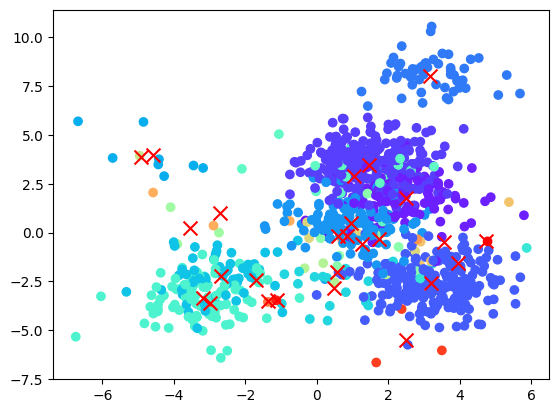

In [ ]:
# Eslicitiamo la likehood di muk rispetto ai dati
# abbiamo vettore assignment, da tradurre come matrice in one-hot-encding

C=np.zeros((n,ntopics))
X=np.array(datapoints)
for i in range(n):
  C[i,assignment[i]]=1
n_cluster = np.sum(C, axis = 0)
m_post=1/(1+1/sigma2**2)/np.matmul(n_cluster.reshape((ntopics,1)),np.ones(shape=(1,d)))*np.matmul(C.T,X)
s2_post=1/(1+1/sigma2**2)/n_cluster

plt.scatter(xs, ys, color=cs)
print('Final number of clusters: ',len(mus))

for i in range(ntopics):
  plt.scatter(m_post[i,0], m_post[i,1], marker='x', color='red', s=100, label=f'Mean Cluster {i}')

plt.show()

## Cluster error

In [ ]:
def error_measure(m_real,s2_real,clus_real,m_pred,s2_pred,clus_pred,ntopics):
  K=ntopics
  N=clus_pred.shape[0]
  weights1=1/K*np.ones((K,))
  weights2=np.mean(clus_pred,axis=1)
  mix1=0
  mix2=0
  inter=0
  d=m_real.shape[1]
  K_pred=len(np.unique(clus_pred))

  for i in np.arange(K):
    for j in np.arange(K):
      s2_ij=s2_real[i]+s2_real[j]
      mix1+=weights1[i]*weights1[j]*multivariate_normal.pdf(m_real[i,],m_real[j,],s2_ij*np.eye(d))
  for i in np.arange(K_pred):
    for j in np.arange(K_pred):
      s2_ij=s2_pred[i]+s2_pred[j]
      mix2+=weights2[i]*weights2[j]*multivariate_normal.pdf(m_pred[i,],m_pred[j,],s2_ij*np.eye(d))
  for i in np.arange(K):
    for j in np.arange(K_pred):
      s2_ij=s2_real[i]+s2_pred[j]
      inter+=weights1[i]*weights2[j]*multivariate_normal.pdf(m_real[i,],m_pred[j,],s2_ij*np.eye(d))

  error_m_s2=mix1+mix2-2*inter
  clus_real_num=np.empty((N,))
  clus_pred_num=np.empty((N,))
  for i in np.arange(N):
    clus_real_num[i]=np.argmax(clus_real[i,])
    clus_pred_num[i]=np.argmax(clus_pred[i,])

  error_clust=1-adjusted_rand_score(clus_real_num,clus_pred_num)
  diff_clus=K-K_pred
  return error_m_s2,error_clust,diff_clus

In [ ]:
m=tau[0]
s2=tau[1]

error_m_s2,error_clust,diff=error_measure(m_post,s2_post,C,m,s2,phi,ntopics)
error_m_s2,error_clust,diff

['#440154', '#46085c', '#471063', '#481769', '#481d6f', '#482576', '#472c7a', '#46327e', '#453882', '#423f85', '#404588', '#3e4a89', '#3c508b', '#39558c', '#365c8d', '#34618d', '#31668e', '#2f6b8e', '#2d718e', '#2b758e', '#297a8e', '#277f8e', '#25838e', '#23898e', '#218e8d', '#20928c', '#1f978b', '#1e9d89', '#1fa187', '#21a685', '#25ab82', '#29af7f', '#31b57b', '#38b977', '#40bd72', '#4ac16d', '#56c667', '#60ca60', '#6ccd5a', '#77d153', '#84d44b', '#93d741', '#a0da39', '#addc30', '#bade28', '#cae11f', '#d8e219', '#e5e419', '#f1e51d', '#fde725']


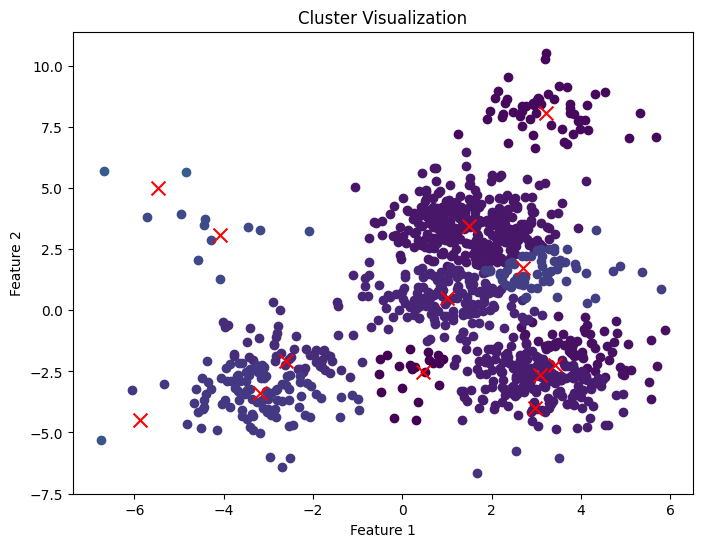

In [ ]:
plot_clusters(X,phi,tau[0])

In [ ]:
np.sum(C,axis=0)

array([  2.,  99., 256., 238.,  54., 120.,   8.,  57.,  19.,   3.,  90.,
        17.,   1.,   8.,   3.,   4.,   1.,   4.,   4.,   3.,   2.,   1.,
         1.,   3.,   1.,   1.])

In [ ]:
clus_assignment=jnp.argmax(phi,axis=1)
tau[0][np.unique(clus_assignment)]

Array([[64.650375, 26.42638 ]], dtype=float32)